In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cmcrameri import cm

import os
from pathlib import Path
import shutil
import gzip
import re
import csv

import timeit

In [2]:
# dataWDBH_path = 'processed_data/WDBH_data.csv'
# data_path = 'data/simulation_data'
dataWDBH_path = 'processed_data/updated_WDBH_data.csv'
data_path = 'data/updated_simulation_data'

id_WD = [10, 11, 12]
id_BH = [14]

In [3]:
# Check repeats
def filter_consecutive_duplicates_with_map(input_list):
    n = len(input_list)
    keep = [True] * n  # Initialize all elements to True in the keep map
    
    i = 1
    while i < n:
        if input_list[i] == input_list[i - 1]:
            # Mark all consecutive identical numbers to False except the last one
            start = i - 1
            while i < n and input_list[i] == input_list[i - 1]:
                keep[i] = False
                i += 1
            keep[start] = True  # Keep the first of the consecutive identical numbers
            keep[i - 1] = True  # Keep the last of the consecutive identical numbers
        i += 1
    return keep


In [4]:
### Filter by age, RLO, and consecutive duplicates
header = "#N,#rv,#rg,#z,#t_snapshot[myr],#M1[MSUN],#M2[MSUN],#k1,#k2,#id1,#id2,#sma[AU],#ecc,#bin_star_radius0[RSUN],#bin_star_radius1[RSUN],#snapshot, #roche_lobe1_calc[RSUN], #roche_lobe2_calc[RSUN],#radrol0,#radrol1"
events_WDBH = []

# Parse the csv file
with open(dataWDBH_path, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        events_WDBH.append(row)
    events_WDBH = np.array(events_WDBH)

print(len(events_WDBH))

# Check age
check_old = np.array(events_WDBH[:, 4], dtype=float) > 9e3
events_old = events_WDBH[check_old]
print(len(events_old))

# Check RLO
check_RLO = ((np.array(events_old[:, 16]).astype(float) < np.array(events_old[:, 13]).astype(float)) | (np.array(events_old[:, 17]).astype(float) < np.array(events_old[:, 14]).astype(float)));
events_RLO = events_old[check_RLO]
print(len(events_RLO))

# Check consecutives
keep = filter_consecutive_duplicates_with_map(events_RLO[:, 9])
events_consec = np.array([events_RLO[idx] for idx, flag in enumerate(keep) if flag])
print(len(events_consec))


5761
909
32
10


[]


C:\Users\willi\AppData\Local\Temp\ipykernel_28924\3438177733.py:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  numbers = np.fromstring(data, sep=' ')


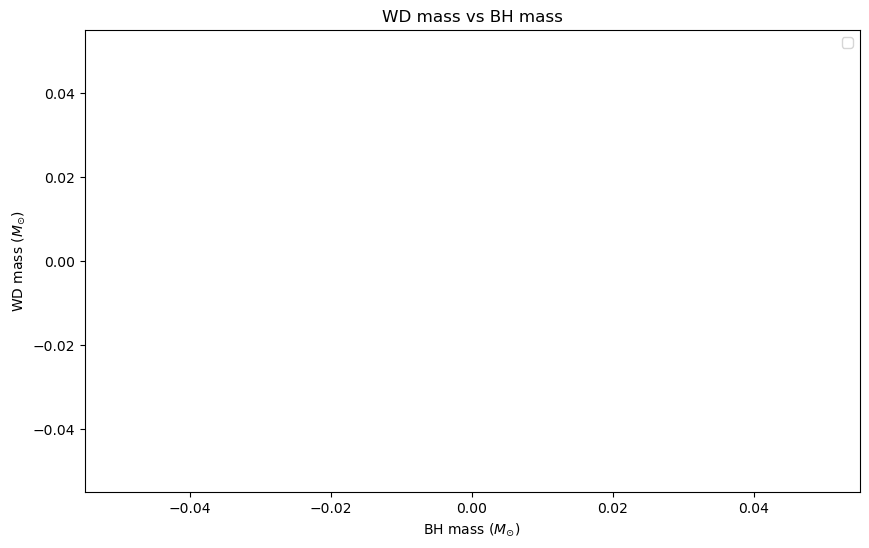

In [5]:

# Read the data from the file
with open(dataWDBH_path, 'r') as file:
    data = file.read()

# Convert the string to a list of numbers
numbers = np.fromstring(data, sep=' ')

# Reshape the data into a 2D array
num_columns = 13
events_WDBH = numbers.reshape(-1, num_columns)



mass_BH = [coll[5] if coll[7] in id_BH else coll[6] for coll in events_WDBH]
mass_WD = [coll[5] if coll[7] in id_WD else coll[6] for coll in events_WDBH]
Ns_WDBH = events_WDBH[::, 0]

markers = ["*", "o", "x"] # change markers for the different metallicity values


colors = cm.batlow(np.linspace(0, 1, len(set(Ns_WDBH))))

# Get unique numbers from the list
unique_numbers = list(set(Ns_WDBH))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in Ns_WDBH]


fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(mass_BH, mass_WD, c=colors_N)
ax.set_xlabel(r'BH mass ($M_{\odot}$)')
ax.set_ylabel(r'WD mass ($M_{\odot}$)')
ax.set_title('WD mass vs BH mass')

# Create a legend
legend_labels = {N: rf'$N={int(N)} \times 10^5$' for N in unique_numbers}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[N]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
ax.legend(handles=legend_handles, loc='best')

print(Ns_WDBH)

In [6]:

outputfiltered_file = 'processed_data/updated_WDBH_filtered.csv'

### Write the data to the output file
with open(outputfiltered_file, 'w') as file:
    # Write the header
    file.write(header + '\n')

    # Write the data
    for row in events_consec:
        file.write(','.join(map(str, row)) + '\n')


DONE print out the radius of the stars too. calculate size of roche lobe (formula), check if wd fills roche lobe. cut the ones that aren't. 

DONE cut interactions ealier than 9gyr. check for repeats, only keep first and last interaction. 


DONE check escaped binaries. i.e. record last binary interaction time, record escape time. 
if not escaped, check binint to see how the binary broke apart. 

to check binary formation, check binint to see when first time binary appears in output (making sure same binary is not in the input). binint produce list of systems, and then check through with data file again if there's any missing in either one. 


DONE use radrol number to create list again.

use binint to find the binary, check ids are the same, calculate roche lobe radius. find latest time the binary appears in binint file with $(t_{enc}<t_{snap})\,\&\,(R_{WD}<R_{RL})$. this tells us about the properties of the binary at formation. probably won't have more interactions that break it apart in between RLO and snapshot. can do by cross checking roche lobe with binint files. 

use binint to get story for the formation of each system

check BH giant collisions from new file


In [7]:
### Filter by age, RLO, and consecutive duplicates
header = "#N,#rv,#rg,#z,#t_snapshot[myr],#M1[MSUN],#M2[MSUN],#k1,#k2,#id1,#id2,#sma[AU],#ecc,#bin_star_radius0[RSUN],#bin_star_radius1[RSUN],#snapshot, #roche_lobe1_calc[RSUN], #roche_lobe2_calc[RSUN],#radrol0,#radrol1"

events_WDBH = []



# Parse the csv file
with open(dataWDBH_path, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        events_WDBH.append(row)
    events_WDBH = np.array(events_WDBH)

print(len(events_WDBH))

# Check age
check_old = np.array(events_WDBH[:, 4], dtype=float) > 9e3
events_old = events_WDBH[check_old]
print(len(events_old))

# Check RLO
check_RLO = ((np.array(events_old[:, 18]).astype(float) > 1) | (np.array(events_old[:, 19]).astype(float) > 1));
events_RLO = events_old[check_RLO]
print(len(events_RLO))

# Check consecutives
keep = filter_consecutive_duplicates_with_map(events_RLO[:, 9])
events_consec = np.array([events_RLO[idx] for idx, flag in enumerate(keep) if flag])
print(len(events_consec))




5761
909
32
10


In [8]:

outputfiltered_file = 'processed_data/updated_WDBH_filtered_radrol.csv'

### Write the data to the output file
with open(outputfiltered_file, 'w') as file:
    # Write the header
    file.write(header + '\n')

    # Write the data
    for row in events_consec:
        file.write(','.join(map(str, row)) + '\n')